#### 6.804 Fall 2019 Final Project
Matthew Johnston (UG) and Isaac Perper (UG)

### Title

Run the code below to visualize the results of the paper as we implemented them.

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import math

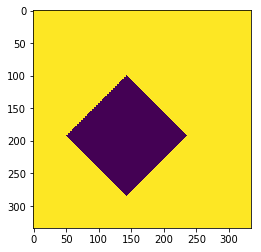

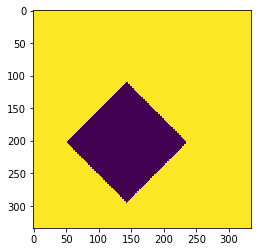

In [181]:
# PARAMETERS -- set the parameters of the image and the rhombus you want
w = 500 # width of image
h = 500 # height of image
length = 128 # side length fo rhombus
offset = 0 # offset of left side from the right side
line_width = 3 # thickness of line

total_height = length + offset
width = np.sqrt(length**2 - offset**2)
slope = offset/width # this is the slope of the two connecting sides

# initialize image
data = np.zeros((w, h), dtype=np.uint8) # start with blank image of size w, h
data[0:w-1, 0:h-1] = 255 
img = Image.fromarray(data, 'L')
contrast_val = 128 

# set right and left sides to black
for i in range(w): # y axis
    for j in range(h): # x axis
        if (j == 150 and (h + length)/2 >= i >= (h - length)/2): # takes care of left side
            data[i, j:j+line_width] = 255 - contrast_val
        elif (j == math.floor(150 + width) and (h + length)/2 >= i >= (h - length)/2): # takes care of right side which is shifted up 
            data[i - offset, j:j+line_width] = 255 - contrast_val

# we need a block just to calculate the actual coordinates for the edges
for j in range(150, math.floor(150 + width) + line_width): # all the x values for which the rhombus will be there
    bottom_y = int(round((j-150) * -1 * slope + (h + length) / 2)) # bottom edge y values
    # data[bottom_y:bottom_y+line_width, j] = 255 - contrast_val
    upper_y = bottom_y - length
    # data[upper_y:upper_y+line_width, j] = 255 - contrast_val
    data[upper_y:bottom_y+line_width, j] = 255 - contrast_val

# can also rotate if we want -- might be harder to get a good resolution though so let's hold off for now
img = img.rotate(45)

translation = 10 # parameter to control how much it translates to the right

img_translate = img.copy()
img_cropped = img.crop((50, 50, w-50, w-50)) # crop to 400x400
# img_cropped.show() # show orginal image cropped
img_translate = img.rotate(0, translate=(0, translation)) # translates right by 20
img_translate_cropped = img_translate.crop((50, 50, w-50, w-50)) # crop to 400x400
# img_translate_cropped.show() # show translated image cropped

data = np.array(img)
data_translated = np.array(img_translate) # this gives us the translated image as np array

crop = 83
initial = data[crop:w-crop, crop:w-crop] # this gives us the original image 400x400
final = data_translated[crop:w-crop, crop:w-crop] # this give us the translated image 400x400

initial = initial.astype('int16')

final = final.astype('int16')
plt.imshow(initial)
plt.show()
plt.imshow(final)
plt.show()

Image.fromarray(initial).show()

In [195]:
# Derivative Functions

def gradient_x(img1):
    '''
    Takes image from time t and computes the spatial derivativee in the x direction.
    Uses 1x3 diffferentiation kernel
    '''
    kernel = np.array([1,-1])
    pad_size = 3
    
    # Pad the image with zeros on top and bottom
    padded = np.hstack((np.tile(img1[:,0:1], (1, pad_size)), img1, np.tile(img1[:,-1:], (1, pad_size))))
        
    # Flatten in column-major form so the kernel convolves along the correct dimensions
    convolved = np.convolve(kernel, padded.ravel(), mode='same')
    return (convolved.reshape(padded.shape)[:, pad_size:pad_size+img1.shape[1]])

def gradient_y(img1):
    '''
    Takes image from time t and computes the spatial derivativee in the y direction.
    Uses 1x3 diffferentiation kernel
    '''
    kernel = np.array([1,-1])
    pad_size = 3
    
    # Pad the image with zeros on top and bottom
    padded = np.vstack((np.tile(img1[0:1,:], (pad_size,1)),img1,np.tile(img1[-1:,:], (pad_size,1))))
    
    # Flatten in column-major form so the kernel convolves along the correct dimensions
    convolved = np.convolve(kernel, padded.ravel('F'), mode='same')
    return (convolved.reshape(padded.shape, order='F')[pad_size:pad_size+img1.shape[0], :])


def gradient_time(img1, img2, dt):
    '''
    Takes image at time t and time t+dt to compute the temporal derivate I_t(x,y,t)
    '''
    return ((img2 - img1))

# img = np.zeros((10, 10))
# img[5:6, :] = 10

# xderiv = gradient_y(img)

# print(img)
# print(xderiv)

In [196]:
# Compute derivative of image test

vx = np.arange(-100, 100, 4)
vy = np.arange(-100, 100, 4)
vxx, vyy = np.meshgrid(vx, vy, sparse=True)

Ix = gradient_x(initial)
Iy = gradient_y(initial)
It = gradient_time(initial, final, 1)

Max: %f -38416.976050073754


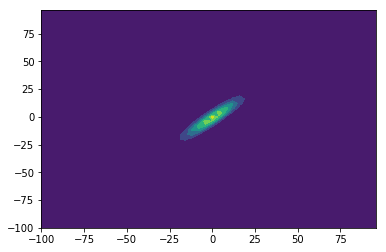

0 0


In [197]:
def likelihood(window, vxi, vyi, Ix, Iy, Iz, sigma_noise = 0.5):
    return -1/(2*sigma_noise**2) * np.sum(window * np.square(Ix*vxi + Iy*vyi + It))

def vel_plot(xi, yi, vxx, vyy, Ix, Iy, It, sigma_noise):
        
    h, w = Ix.shape
    imx = np.arange(0, w)
    imy = np.arange(0, h)
    imxx, imyy = np.meshgrid(imx, imy, sparse=True)

    window = np.exp(-((imxx-xi)**2+(imyy-yi)**2)/(2*sigma_noise**2))
#     plt.imshow(window)
#     plt.show()
#     plt.imshow(img)
#     plt.show()
    
    arr = np.zeros((vyy.shape[0], vxx.shape[1]))
    
    for i, v_y in np.ndenumerate(vyy):
        for j, v_x in np.ndenumerate(vxx):
            
            arr[i[0],j[1]] = likelihood(window, v_x, v_y, Ix, Iy, It, sigma_noise)

    print("Max: %f", np.max(arr))
    plt.contourf(vxx[0,:], vyy[:,0], np.exp(arr/1000000))
    plt.show()
    
    return arr

# Prior
# def prior(vx, vy, sigma_p=1):
#     return -255*np.abs(vx*vx+vy*vy)/(2*sigma_p**2)

# # Prior
# def tot_prior(vxx, vyy, sigma_p=1):
#     return np.exp(-np.abs(vxx*vxx+vyy*vyy)/(2*sigma_p**2))


# def tot_likelihood(vx, vy, Ix, Iy, It, sigma_noise=10):
#     return -1/(2*sigma_noise**2)*np.sum(np.square(Ix*vx + Iy*vy + It))
    
arr = vel_plot(143, 100, vxx, vyy, Ix, Iy, It, 0.5)

vx_maxi, vy_maxi = np.unravel_index(np.argmax(arr, axis=None), arr.shape)
vx_max = vx[vx_maxi]
vy_max = vy[vy_maxi]

print(vx_max, vy_max)

In [198]:
# print(np.argmax(arr[0,:]))
# plt.plot(arr[0,:])
# plt.show()

In [193]:
def v_star(Ix, Iy, It, sigma_p, sigma):
    arr1 = np.array([[np.sum(np.square(Ix))+sigma**2/sigma_p**2, np.sum(Ix*Iy)],
                     [np.sum(Ix*Iy), np.sum(np.square(Iy))+sigma**2/sigma_p**2]])
    arr2 = np.array([[np.sum(Ix*It)],
                    [np.sum(Iy*It)]])
    print(arr1.shape)
    print(arr2.shape)
    
    return -np.dot(np.linalg.inv(arr1), arr2)
    
v_star(Ix, Iy, It, 1, 100)

(2, 2)
(2, 1)


array([[0.01544023],
       [0.9636632 ]])